In [ ]:
import yfinance as yf
import pandas as pd

stock = yf.download('NVDA', start='2019-12-20', end='2024-02-10')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
full_date_range = pd.date_range(start=stock.index.min(), end=stock.index.max())
closed_market_days = full_date_range.difference(stock.index)

In [ ]:
df_bert = pd.read_csv('nvidia_articles_bert.csv')
df_finbert = pd.read_csv('nvidia_articles_finbert.csv')

In [ ]:
stock = stock[~stock.index.isin(closed_market_days)]
stock['Stock_Price_Change'] = stock['Close'].diff()
stock.dropna()

,Open,High,Low,Close,Adj Close,Volume,Stock_Price_Change
Date,,,,,,,
2019-12-23,60.130001,60.452499,59.597500,59.705002,59.469814,35506000,-0.137497
2019-12-24,59.549999,59.827499,59.205002,59.654999,59.420006,13886400,-0.050003
2019-12-26,59.689999,60.080002,59.500000,59.797501,59.561954,18285200,0.142502
2019-12-27,59.950001,60.084999,58.952499,59.217499,58.984226,25464400,-0.580002
2019-12-30,58.997501,59.049999,57.764999,58.080002,57.851208,25805600,-1.137497
...,...,...,...,...,...,...,...
2024-02-05,682.250000,694.969971,672.049988,693.320007,693.287476,68007800,31.720032
2024-02-06,696.299988,697.539978,663.000000,682.229980,682.197998,68311100,-11.090027
2024-02-07,683.190002,702.200012,676.000000,700.989990,700.957092,49557500,18.760010


In [ ]:
# Convert the published date to datetime format if not already done
df_bert['published'] = pd.to_datetime(df_bert['published'], format='%Y-%m-%d %H:%M:%S')
df_finbert['published'] = pd.to_datetime(df_finbert['published'], format='%Y-%m-%d %H:%M:%S')

# Extract date part only for merging and convert to datetime64[ns] type
df_bert['published_date'] = pd.to_datetime(df_bert['published'].dt.date)
df_finbert['published_date'] = pd.to_datetime(df_finbert['published'].dt.date)

In [ ]:
df_bert['published_date'] = pd.to_datetime(df_bert['published_date'])
df_finbert['published_date'] = pd.to_datetime(df_finbert['published_date'])

# Correct the merge statements
df_bert = df_bert.merge(stock[['Stock_Price_Change', 'Volume']], left_on='published_date', right_index=True)
df_finbert = df_finbert.merge(stock[['Stock_Price_Change', 'Volume']], left_on='published_date', right_index=True)

In [ ]:
def numeric_score_bert(row):
  if row['sentiment'] == 'POSITIVE':
    return row['sentiment_score']
  elif row['sentiment'] == 'NEGATIVE':
    return -row['sentiment_score']
  else:
    return 0
df_bert['numeric_score'] = df_bert.apply(numeric_score_bert, axis=1)

In [ ]:
def numeric_score_finbert(row):
  if row['sentiment'] == 'Positive':
    return row['sentiment_score']
  elif row['sentiment'] == 'Negative':
    return -row['sentiment_score']
  else:
    return 0
df_finbert['numeric_score'] = df_finbert.apply(numeric_score_finbert, axis=1)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

df_granger_bert = df_bert[['numeric_score', 'Stock_Price_Change']].dropna()
df_granger_finbert = df_finbert[['numeric_score', 'Stock_Price_Change']].dropna()

# Perform Granger Causality Test for BERT sentiment scores
max_lag = 15  # You can choose an appropriate lag
print("Granger Causality Test for BERT Sentiment Scores")
granger_results_bert = grangercausalitytests(df_granger_bert, max_lag, verbose=True)

# Perform Granger Causality Test for FinBERT sentiment scores
print("\nGranger Causality Test for FinBERT Sentiment Scores")
granger_results_finbert = grangercausalitytests(df_granger_finbert, max_lag, verbose=True)

# Interpret results
def interpret_granger_results(granger_results):
    for lag, test_result in granger_results.items():
        f_test_p_value = test_result[0]['ssr_ftest'][1]
        print(f'Lag {lag}: F-test p-value = {f_test_p_value}')

print("\nInterpreting Granger Causality Test Results for BERT")
interpret_granger_results(granger_results_bert)

print("\nInterpreting Granger Causality Test Results for FinBERT")
interpret_granger_results(granger_results_finbert)

Granger Causality Test for BERT Sentiment Scores

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.0700 , p=0.0000  , df_denom=23729, df_num=1
ssr based chi2 test:   chi2=17.0721 , p=0.0000  , df=1
likelihood ratio test: chi2=17.0660 , p=0.0000  , df=1
parameter F test:         F=17.0700 , p=0.0000  , df_denom=23729, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.0361  , p=0.0003  , df_denom=23726, df_num=2
ssr based chi2 test:   chi2=16.0757 , p=0.0003  , df=2
likelihood ratio test: chi2=16.0702 , p=0.0003  , df=2
parameter F test:         F=8.0361  , p=0.0003  , df_denom=23726, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6717  , p=0.0007  , df_denom=23723, df_num=3
ssr based chi2 test:   chi2=17.0201 , p=0.0007  , df=3
likelihood ratio test: chi2=17.0140 , p=0.0007  , df=3
parameter F test:         F=5.6717  , p=0.0007  , df_denom=23723, df_num=3

Granger Causality
number of lags

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=5.8366  , p=0.0001  , df_denom=23720, df_num=4
ssr based chi2 test:   chi2=23.3554 , p=0.0001  , df=4
likelihood ratio test: chi2=23.3439 , p=0.0001  , df=4
parameter F test:         F=5.8366  , p=0.0001  , df_denom=23720, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.5952  , p=0.0003  , df_denom=23717, df_num=5
ssr based chi2 test:   chi2=22.9868 , p=0.0003  , df=5
likelihood ratio test: chi2=22.9757 , p=0.0003  , df=5
parameter F test:         F=4.5952  , p=0.0003  , df_denom=23717, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.7844  , p=0.0009  , df_denom=23714, df_num=6
ssr based chi2 test:   chi2=22.7190 , p=0.0009  , df=6
likelihood ratio test: chi2=22.7081 , p=0.0009  , df=6
parameter F test:         F=3.7844  , p=0.0009  , df_denom=23714, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.2332  , p=0.0020  , df_denom=23711, df_num=7
ssr bas

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, May, 2024
Time:                     21:32:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.22112
Nobs:                     23719.0    HQIC:                   1.20778
Log likelihood:          -81501.3    FPE:                    3.32468
AIC:                      1.20137    Det(Omega_mle):         3.31657
--------------------------------------------------------------------
Results for equation Stock_Price_Change
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.004805         0.023890            0.201           0.841
L1.Stock_Price_Change          0.984337         0.006497          151.511           0.000
L1.numeric_

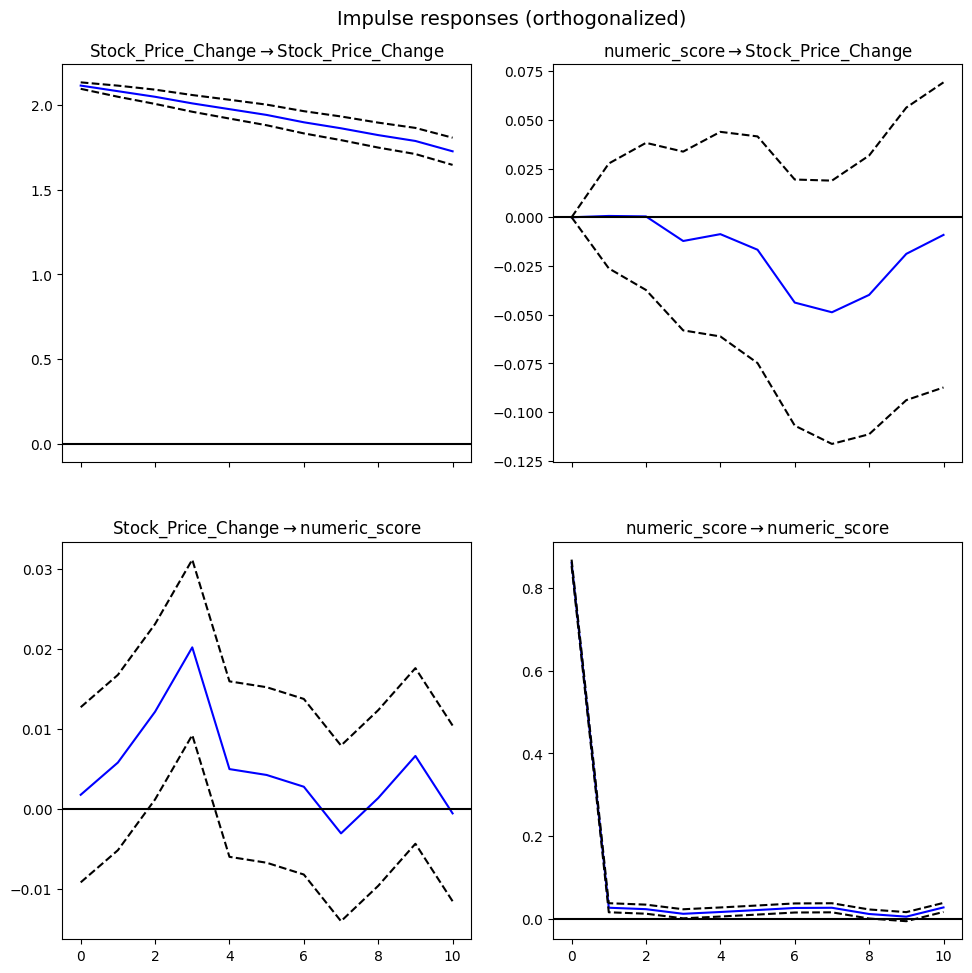

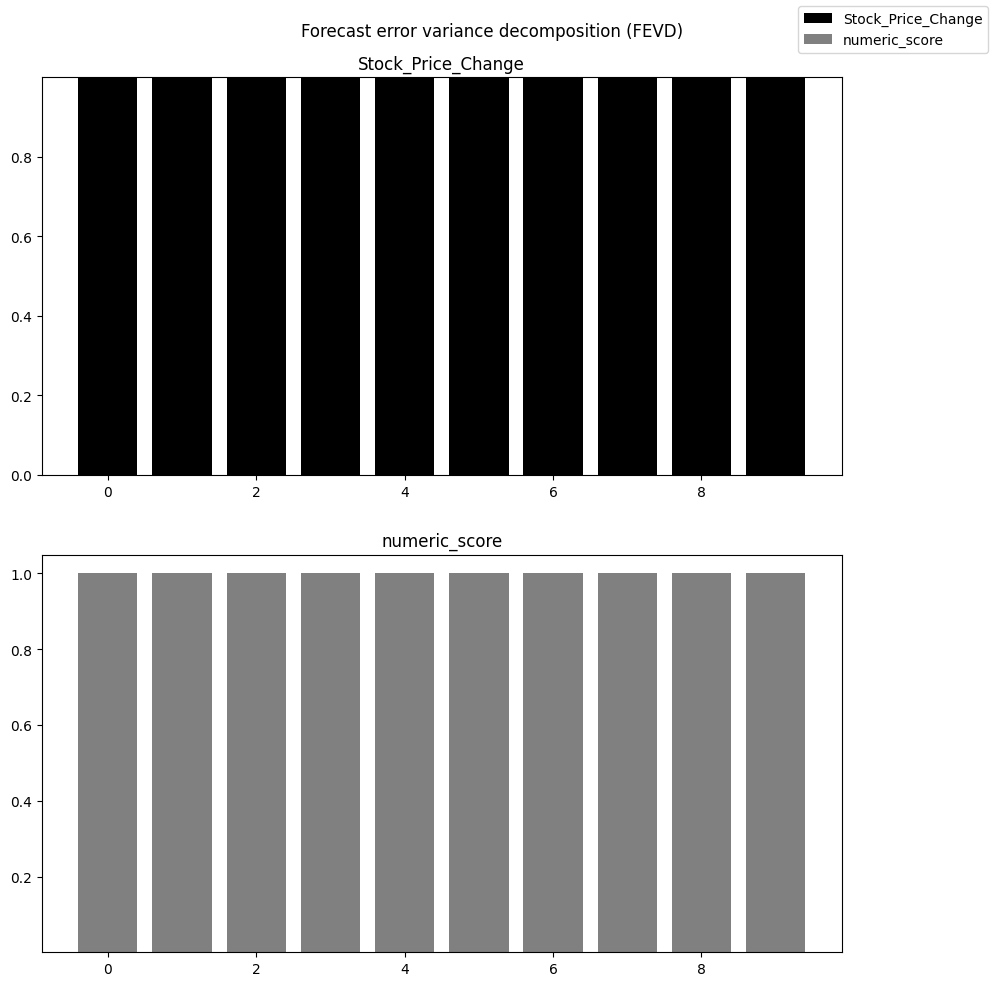

In [ ]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Prepare the data for VAR model
# Using differenced stock prices and original BERT sentiment scores
var_data = df_bert[['Stock_Price_Change', 'numeric_score']].dropna()

# Fit the VAR model
model = VAR(var_data)
results = model.fit(maxlags=15, ic='aic')

# Summary of the model
print(results.summary())

# Impulse Response Function
irf = results.irf(10)
irf.plot(orth=True)
plt.show()

# Forecast Error Variance Decomposition
fevd = results.fevd(10)
fevd.plot()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, May, 2024
Time:                     21:33:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.120619
Nobs:                     23124.0    HQIC:                  0.106050
Log likelihood:          -66706.2    FPE:                    1.10411
AIC:                    0.0990386    Det(Omega_mle):         1.10115
--------------------------------------------------------------------
Results for equation Stock_Price_Change
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.018815         0.017960            1.048           0.295
L1.Stock_Price_Change          0.984696         0.006580          149.643           0.000
L1.numeric_

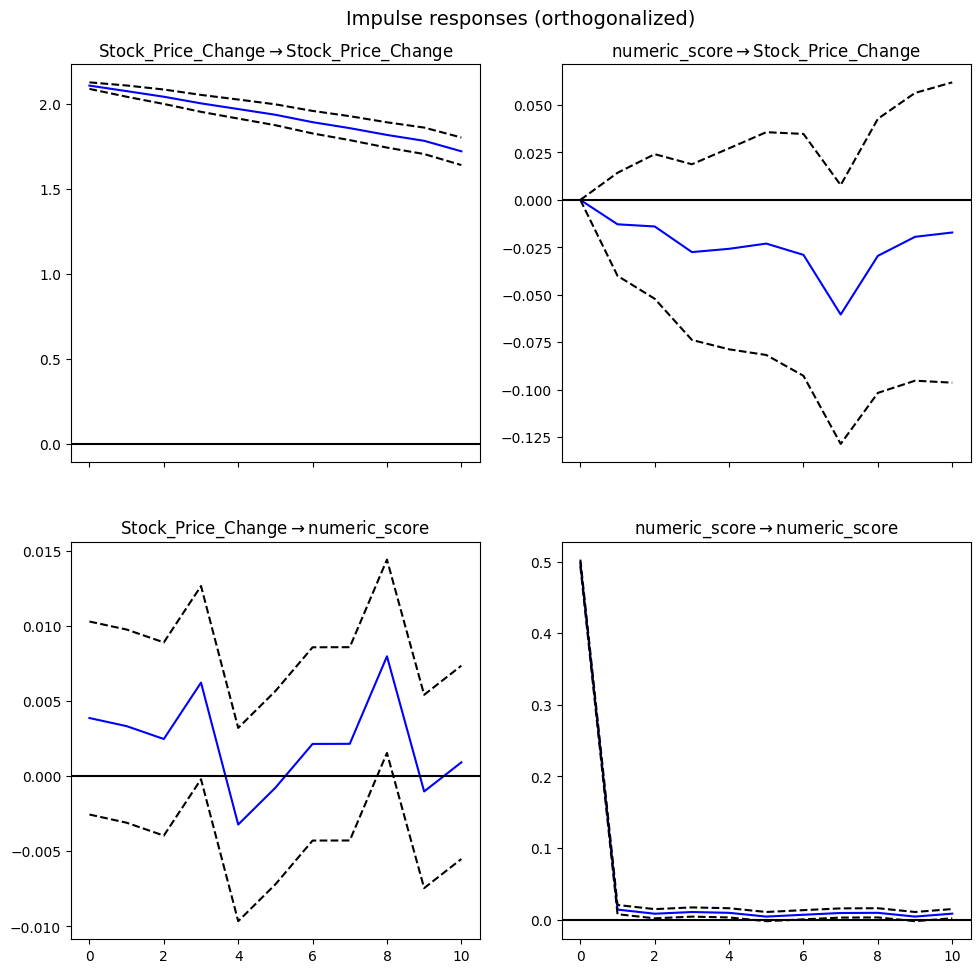

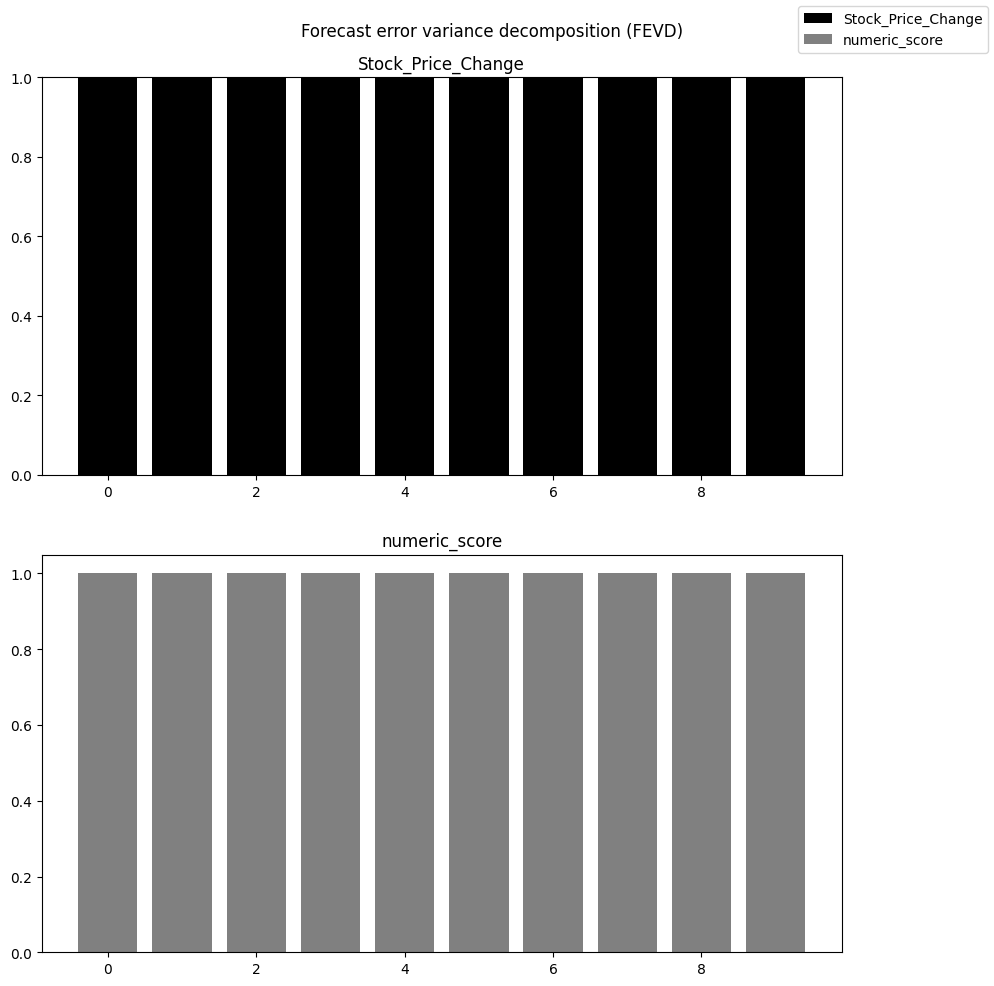

In [ ]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Prepare the data for VAR model
# Using differenced stock prices and original FinBERT sentiment scores
var_data = df_finbert[['Stock_Price_Change', 'numeric_score']].dropna()

# Fit the VAR model
model = VAR(var_data)
results = model.fit(maxlags=15, ic='aic')

# Summary of the model
print(results.summary())

# Impulse Response Function
irf = results.irf(10)
irf.plot(orth=True)
plt.show()

# Forecast Error Variance Decomposition
fevd = results.fevd(10)
fevd.plot()
plt.show()


BERT

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

lags = [1, 5, 6]
for lag in lags:
    df_bert[f'Stock_Price_Change_lag{lag}'] = df_bert['Stock_Price_Change'].shift(lag)
    df_bert[f'numeric_score_lag{lag}'] = df_bert['numeric_score'].shift(lag)

df_bert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_bert[features]
y = df_bert[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training a Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predicting on the test set
y_pred = model_rf.predict(X_test)

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# You can also calculate other metrics if needed, such as R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 5.608887458724584
R-squared: 0.9365917017885944


In [ ]:
importances = model_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                   Feature  Importance
0  Stock_Price_Change_lag1    0.946496
5       numeric_score_lag6    0.016717
4       numeric_score_lag5    0.016443
3       numeric_score_lag1    0.014180
2  Stock_Price_Change_lag6    0.003337
1  Stock_Price_Change_lag5    0.002827


In [ ]:
# Initialize the Random Forest model with the best parameters
final_model_bert = RandomForestRegressor(
    bootstrap=True,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=200,
    random_state=42
)

# Train the final model on the training data
final_model_bert.fit(X_train, y_train)

# Predict on the test set
y_pred_final = final_model_bert.predict(X_test)

# Calculate the Mean Squared Error and R-squared
mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f'Final Model Mean Squared Error: {mse_final}')
print(f'Final Model R-squared: {r2_final}')

Final Model Mean Squared Error: 4.969724599185598
Final Model R-squared: 0.9438174180293903


In [ ]:
from xgboost import XGBRegressor

# Initialize and train an XGBoost model
xgb_model_bert = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model_bert.fit(X_train, y_train)

# Predict and evaluate the XGBoost model
y_pred_xgb = xgb_model_bert.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost R-squared: {r2_xgb}')

XGBoost Mean Squared Error: 5.881923375037061
XGBoost R-squared: 0.9335050392496561


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score


lags = [1, 5, 6]
for lag in lags:
    df_bert[f'Stock_Price_Change_lag{lag}'] = df_bert['Stock_Price_Change'].shift(lag)
    df_bert[f'numeric_score_lag{lag}'] = df_bert['numeric_score'].shift(lag)

df_bert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_bert[features]
y = df_bert[target]

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Reshaping the data to 3D format for LSTM: [samples, time steps, features]
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reshaped, y, test_size=0.2, random_state=42)

# Building the LSTM model
model_lstm_bert = Sequential()
model_lstm_bert.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_bert.add(LSTM(units=50))
model_lstm_bert.add(Dense(1))

# Compiling the model
model_lstm_bert.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the model
history = model_lstm_bert.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Predicting on the test set
y_pred = model_lstm_bert.predict(X_test)

# Calculating the Mean Squared Error and R-squared
mse_lstm = mean_squared_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)

print(f'LSTM Mean Squared Error: {mse_lstm}')
print(f'LSTM R-squared: {r2_lstm}')


Epoch 1/20
475/475 [==============================] - 6s 6ms/step - loss: 53.5611 - val_loss: 20.0877
Epoch 2/20
475/475 [==============================] - 2s 4ms/step - loss: 17.1225 - val_loss: 10.2147
Epoch 3/20
475/475 [==============================] - 2s 5ms/step - loss: 11.5838 - val_loss: 7.8907
Epoch 4/20
475/475 [==============================] - 2s 5ms/step - loss: 9.7216 - val_loss: 6.9002
Epoch 5/20
475/475 [==============================] - 2s 4ms/step - loss: 8.5810 - val_loss: 6.2818
Epoch 6/20
475/475 [==============================] - 2s 4ms/step - loss: 7.7373 - val_loss: 5.9092
Epoch 7/20
475/475 [==============================] - 2s 4ms/step - loss: 7.0756 - val_loss: 5.3893
Epoch 8/20
475/475 [==============================] - 2s 4ms/step - loss: 6.5100 - val_loss: 5.2490
Epoch 9/20
475/475 [==============================] - 2s 4ms/step - loss: 6.0311 - val_loss: 4.8146
Epoch 10/20
475/475 [==============================] - 3s 7ms/step - loss: 5.6710 - val_loss: 4

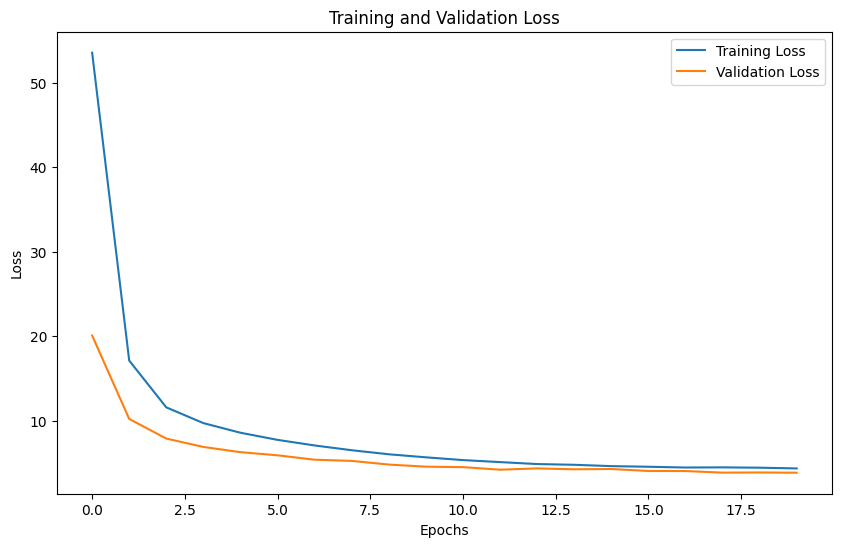

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on training set
y_train_pred = model_lstm_bert.predict(X_train)

# Calculate the Mean Squared Error and R-squared for training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f'Training Mean Squared Error: {mse_train}')
print(f'Training R-squared: {r2_train}')

# Predict on test set
y_test_pred = model_lstm_bert.predict(X_test)

# Calculate the Mean Squared Error and R-squared for test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {mse_test}')
print(f'Test R-squared: {r2_test}')


593/593 [==============================] - 1s 2ms/step
Training Mean Squared Error: 4.166254824290592
Training R-squared: 0.9467708831672896
149/149 [==============================] - 0s 2ms/step
Test Mean Squared Error: 5.8900422844255305
Test R-squared: 0.9312353597158302


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

lags = [1, 5, 6]
for lag in lags:
    df_bert[f'Stock_Price_Change_lag{lag}'] = df_bert['Stock_Price_Change'].shift(lag)
    df_bert[f'numeric_score_lag{lag}'] = df_bert['numeric_score'].shift(lag)

df_bert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_bert[features]
y = df_bert[target]

# Reset the index to ensure continuous indices
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Reshaping the data to 3D format for LSTM: [samples, time steps, features]
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_scaled_reshaped):
    X_train, X_test = X_scaled_reshaped[train_index], X_scaled_reshaped[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build the LSTM model
    model_lstm_bert = Sequential()
    model_lstm_bert.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm_bert.add(LSTM(units=50))
    model_lstm_bert.add(Dense(1))

    # Compile the model
    model_lstm_bert.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model_lstm_bert.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    # Predict on the test set
    y_pred = model_lstm_bert.predict(X_test)

    # Calculate the Mean Squared Error and R-squared
    mse_lstm = mean_squared_error(y_test, y_pred)
    r2_lstm = r2_score(y_test, y_pred)

    mse_scores.append(mse_lstm)
    r2_scores.append(r2_lstm)

# Calculate the average and standard deviation of the scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f'Average LSTM Mean Squared Error: {mean_mse} ± {std_mse}')
print(f'Average LSTM R-squared: {mean_r2} ± {std_r2}')


149/149 [==============================] - 1s 2ms/step
Average LSTM Mean Squared Error: 4.682570259244932 ± 0.8006072345837265
Average LSTM R-squared: 0.9410731579327543 ± 0.011141972997559852


FinBERT

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

lags = [1,  7, 8]
for lag in lags:
    df_finbert[f'Stock_Price_Change_lag{lag}'] = df_finbert['Stock_Price_Change'].shift(lag)
    df_finbert[f'numeric_score_lag{lag}'] = df_finbert['numeric_score'].shift(lag)

df_finbert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_finbert[features]
y = df_finbert[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training a Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predicting on the test set
y_pred = model_rf.predict(X_test)

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# You can also calculate other metrics if needed, such as R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 5.926070400959335
R-squared: 0.9193149302820023


In [ ]:
# Initialize the Random Forest model with the best parameters
final_model = RandomForestRegressor(
    bootstrap=True,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=200,
    random_state=42
)

# Train the final model on the training data
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred_final = final_model.predict(X_test)

# Calculate the Mean Squared Error and R-squared
mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f'Final Model Mean Squared Error: {mse_final}')
print(f'Final Model R-squared: {r2_final}')

Final Model Mean Squared Error: 4.919985679877787
Final Model R-squared: 0.9330130489964772


In [ ]:
from xgboost import XGBRegressor

# Initialize and train an XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate the XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost R-squared: {r2_xgb}')

XGBoost Mean Squared Error: 5.687111768784622
XGBoost R-squared: 0.9225684174315327


In [ ]:
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                   Feature  Importance
0  Stock_Price_Change_lag1    0.991046
5       numeric_score_lag8    0.003023
3       numeric_score_lag1    0.002227
4       numeric_score_lag7    0.001735
2  Stock_Price_Change_lag8    0.001219
1  Stock_Price_Change_lag7    0.000750


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score


lags = [1, 7, 8]
for lag in lags:
    df_finbert[f'Stock_Price_Change_lag{lag}'] = df_finbert['Stock_Price_Change'].shift(lag)
    df_finbert[f'numeric_score_lag{lag}'] = df_finbert['numeric_score'].shift(lag)

df_finbert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_finbert[features]
y = df_finbert[target]

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Reshaping the data to 3D format for LSTM: [samples, time steps, features]
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reshaped, y, test_size=0.2, random_state=42)

# Building the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

# Compiling the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the model
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Predicting on the test set
y_pred = model_lstm.predict(X_test)

# Calculating the Mean Squared Error and R-squared
mse_lstm = mean_squared_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)

print(f'LSTM Mean Squared Error: {mse_lstm}')
print(f'LSTM R-squared: {r2_lstm}')


Epoch 1/20
462/462 [==============================] - 7s 8ms/step - loss: 51.1981 - val_loss: 22.9284
Epoch 2/20
462/462 [==============================] - 2s 4ms/step - loss: 16.9862 - val_loss: 13.9727
Epoch 3/20
462/462 [==============================] - 2s 3ms/step - loss: 11.9322 - val_loss: 11.6889
Epoch 4/20
462/462 [==============================] - 2s 4ms/step - loss: 10.0879 - val_loss: 10.2918
Epoch 5/20
462/462 [==============================] - 2s 4ms/step - loss: 8.9300 - val_loss: 9.6530
Epoch 6/20
462/462 [==============================] - 2s 4ms/step - loss: 8.0892 - val_loss: 8.7810
Epoch 7/20
462/462 [==============================] - 2s 4ms/step - loss: 7.3419 - val_loss: 8.3524
Epoch 8/20
462/462 [==============================] - 2s 5ms/step - loss: 6.7929 - val_loss: 7.9257
Epoch 9/20
462/462 [==============================] - 2s 5ms/step - loss: 6.3086 - val_loss: 7.3741
Epoch 10/20
462/462 [==============================] - 2s 4ms/step - loss: 5.9016 - val_loss

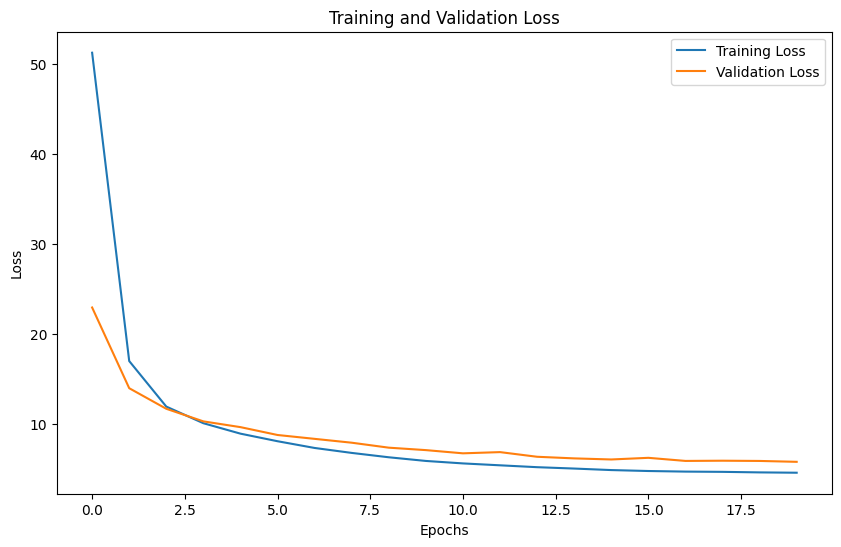

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on training set
y_train_pred = model_lstm.predict(X_train)

# Calculate the Mean Squared Error and R-squared for training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f'Training Mean Squared Error: {mse_train}')
print(f'Training R-squared: {r2_train}')

# Predict on test set
y_test_pred = model_lstm.predict(X_test)

# Calculate the Mean Squared Error and R-squared for test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {mse_test}')
print(f'Test R-squared: {r2_test}')


578/578 [==============================] - 2s 4ms/step
Training Mean Squared Error: 4.766974524120461
Training R-squared: 0.9406241058832969
145/145 [==============================] - 0s 3ms/step
Test Mean Squared Error: 3.88346437763732
Test R-squared: 0.9502222824244366


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data with lag features
lags = [1,  7, 8]
for lag in lags:
    df_finbert[f'Stock_Price_Change_lag{lag}'] = df_finbert['Stock_Price_Change'].shift(lag)
    df_finbert[f'numeric_score_lag{lag}'] = df_finbert['numeric_score'].shift(lag)

df_finbert.dropna(inplace=True)

features = [f'Stock_Price_Change_lag{lag}' for lag in lags] + [f'numeric_score_lag{lag}' for lag in lags]
target = 'Stock_Price_Change'

X = df_finbert[features]
y = df_finbert[target]

# Reset the index to ensure continuous indices
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Reshaping the data to 3D format for LSTM: [samples, time steps, features]
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_scaled_reshaped):
    X_train, X_test = X_scaled_reshaped[train_index], X_scaled_reshaped[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build the LSTM model
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm.add(LSTM(units=50))
    model_lstm.add(Dense(1))

    # Compile the model
    model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    # Predict on the test set
    y_pred = model_lstm.predict(X_test)

    # Calculate the Mean Squared Error and R-squared
    mse_lstm = mean_squared_error(y_test, y_pred)
    r2_lstm = r2_score(y_test, y_pred)

    mse_scores.append(mse_lstm)
    r2_scores.append(r2_lstm)

# Calculate the average and standard deviation of the scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f'Average LSTM Mean Squared Error: {mean_mse} ± {std_mse}')
print(f'Average LSTM R-squared: {mean_r2} ± {std_r2}')


145/145 [==============================] - 2s 2ms/step
Average LSTM Mean Squared Error: 4.569302947606239 ± 0.7866236430929417
Average LSTM R-squared: 0.942855779634785 ± 0.009075138564276254
